Formation OpenClassrooms DS-IML - **Marc Lefèvre**, <marc.lefevre@noos.fr>

# **Projet 4 : OLIST Customers Clustering**

# **Troisième Partie : Recherche de "Personna"**

## **Démarche**

Nous allons maintenant tenter de **pousser plus loin** notre première segmentation des clients dérivée d'un segmentation **RFM** classique.<br><br>Au cours de celle-ci nous avons effectué une sorte de segmentation **de base** selon certains **critères fondamentaux** qu'ont des clients au regard d'un commerce.<br><br>Grâce à nos outils de **machine learning non-supervisé** nous allons à présent essayer d'extraire des données à disposition ce qu'on appelle des **personna**, c'est à dire des profils de **clients types** qui seraient représentatifs d'un segment.

Nous pourrions procéder à ces recherches dans l'ensemble de la base client, en utilisant juste d'autres variables que celles utilisées lors de l'épisode **RFM**. Cependant, étant données les caratéristiques particulières de cette base, et le découpage basée sur la fréquence d'achat qui en est ressorti, il nous parait plus judicieux de procéder autrement en travaillant à partir des grands groupes que nous avons constitués.<br><br>C'est donc de chaque groupe **Gold**, **Silver** et **Bronze** que nous allons essayer d'extraire nos **clients types**.

**Déroulement :**

Pour chacun de ces groupes, nous allons essayer d'obtenir des segmentations, et des **personna** associées grâce au module **K-Modes**, qui est une déclinaison de **K-Means** adaptée aux variables catégorielles.<br><br>En cas de résultats non satisfaisants, nous utiliserons l'algorithme **DBScan**, plus gourmand en ressources, mais capable de procéder à des segmentations (concaves) plus fines.<br><br>Une fois la segmentation obtenue, nous analyserons les différents clusters afin d'en tirer les **traits** des **personna** correspondantes.

### Utilisation de **K-Modes**

Comme avec **K-Means**, nous prendrons en compte la **méthode du coude** et le **silhouette score** pour déterminer à chaque fois le nombre **k** de clusters.<br><br>Nous vérifierons aussi graphiquement la qualité de ces segmentations grâce à une représentation à dimension réduite des données obtenue par **T-SNE**.

### Utilisation de **DBScan**

Cet algorithme fonctionne différemment des précédents. Avec lui on ne part pas du nombre de clusters que l'on veut, mais du réglage d'hyper-paramètres muni desquels l'algorithme renverra une segmentation particulière.<br><br>Pour obtenir une segmentation affichant des caractéristiques qui nous sembleront satisfaisantes (nombre de clusters, nombre de clients par cluster...) nous procèderons par **boucle** à travers des listes de valeurs des hyper-paramètres concernés.<br><br>Quand une segmentation nous semblera valable selon ces critères, nous vérifierons son **silhouette score** et sa représentation graphique, grâce encore à des données de dimension réduite pat **T-SNE**.

## **Opérations préliminaires**

### Importation des bibliothèques python utiles

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
import pickle
import warnings



import plotly
import plotly.graph_objects as go
import urllib, json

from tqdm.notebook import trange, tqdm
from time import sleep

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.ensemble import IsolationForest
from chord import Chord

from sklearn.manifold import TSNE

from time import time

from mpl_toolkits.mplot3d import Axes3D

from yellowbrick.cluster import KElbowVisualizer

from kmodes.kmodes import KModes

from sklearn.metrics import silhouette_samples, silhouette_score

pd.options.display.max_columns = 60

# instruction évitant les avertissements, nombreux lors de l'utilisation du module de TargetEncoder
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

sns.set()

### Fonctions utiles

Fonction permettant d'utiliser **DBScan** sur une grille de paramètres.<br>Elle renvoie différentes caractéristiques des segmentations obtenues, ce qui nous permettra de procéder à notre choix.<br>Nous décidons, afin de ne pas nous retrouver éventuellement avec des *foules de personna*, de ne considérer que les segmentations dont le nombres de cluster ne **dépasse pas 5**.<br>Nous utilisons le module **TQDM** afin de suivre l'avancemment des boucles et d'éventuellement identifier les sources de certains problèmes.

In [27]:
def grid_dbs(df, l_metrics, l_ms, l_eps, str_name) :
    
    dic_db = {"nb_cl" : [],
              "metric" : [],
              "eps" : [],
              "min_s" : [], 
              "pop_cl" : [],
              "temps" : []
             }

    for metr in tqdm(l_metrics) :

        for ms in tqdm(l_ms):

            for n in tqdm(l_eps) :
                
                start = time()
                db = DBSCAN(eps=n, min_samples=ms, metric = metr, algorithm = 'auto').fit(df)
                temps = time() - start
                res = pd.DataFrame()
                res["db_1"] = db.labels_
                nb_cl = res["db_1"].unique().shape[0]

                if nb_cl == 1 :

                    break

                if nb_cl <= 5 :

                    dic_db["nb_cl"].append(nb_cl)
                    dic_db["metric"].append(metr)
                    dic_db["eps"].append(n)
                    dic_db["min_s"].append(ms)
                    dic_db["pop_cl"].append(res["db_1"].value_counts().values)
                    dic_db["temps"].append(temps)

    df_res = pd.DataFrame(dic_db)
    pickle_out = open("Data/df_res_" + str_name + ".pickle", "wb")
    pickle.dump(df_res, pickle_out)
    pickle_out.close()

    return df_res

Fonction transformant des données afin d'obtenir des **barplot** pratiques pour comparer comment différents clusters peupleront différentes catégories.

In [216]:
def transform_data(df, col):
    
    dat = df.copy()
    
    for n in dat[col].value_counts().values:
        
        if n == 0 :
            
            dat[col] = dat[col].cat.remove_unused_categories() 
    
    data = dat.groupby(col)["cluster"].value_counts().rename("pourcentage").reset_index()

    liste_cluster = dat["cluster"].value_counts().index.to_list()
    pop_cluster = dat["cluster"].value_counts().values

    def map_pop(x):

        return pop_cluster[liste_cluster.index(x)]

    data["cluster_pop"] = data["cluster"].apply(map_pop)

    data["pourcentage"] = (data["pourcentage"] / data["cluster_pop"]) * 100
    
    data = data.drop("cluster_pop", axis = 1)
    
    return data

Fonction qui nous permettra d'afficher des graphiques plus facilement.

In [ ]:
def show_graph(data, col, height, aspect, rot = 0) :
    
    graph = sns.catplot(x = col, 
                    y = 'pourcentage', 
                    hue = "cluster", 
                    kind = 'bar', 
                    data = data, 
                    height = height, 
                    aspect = aspect)

    graph.set_xticklabels(rotation=rot)

    plt.title(f"Populations de {col}")

    plt.show()

Fonction générant des graphs de segmentation à partir de réductions dimensionelles des données par T-SNE.

In [262]:
def graph_tsne(df, pred, nb_cl):
    
    plt.figure(figsize = (15,15))
    sns.scatterplot(x = "tsne_1", 
                    y = "tsne_2",
                    hue = pred,
                    palette = sns.color_palette("hls", nb_cl),
                    data = df,
                    legend = "full",
                    alpha = 0.5
                   )
    plt.show()  

### Chargement et nettoyage des données

In [7]:
df = pickle.load(open("Data/full_data.pickle", "rb"))

df = df[['customer_unique_id', 'customer_city',
       'customer_state', 'order_status',
       'month', 'day', 'quarter', 'day_q',
       'product_category_name_english', 'order_vol_cm3', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'review_score',
       'review', 'time_to_carrier',
       'time_from_carrier', 'time_to_cust', 'est_time_ship', 'late_ship',
       'late_carrier', 'seller_city',
       'seller_state', 'problem', 'outlier', 'M_class', 'Classe_RF']]

### Simplification de la variable **product_category_name_english**

Nous allons utiliser cette variable, décrivant la catégorie des produits achetés par les clients. Voici sa distribution par catégorie :

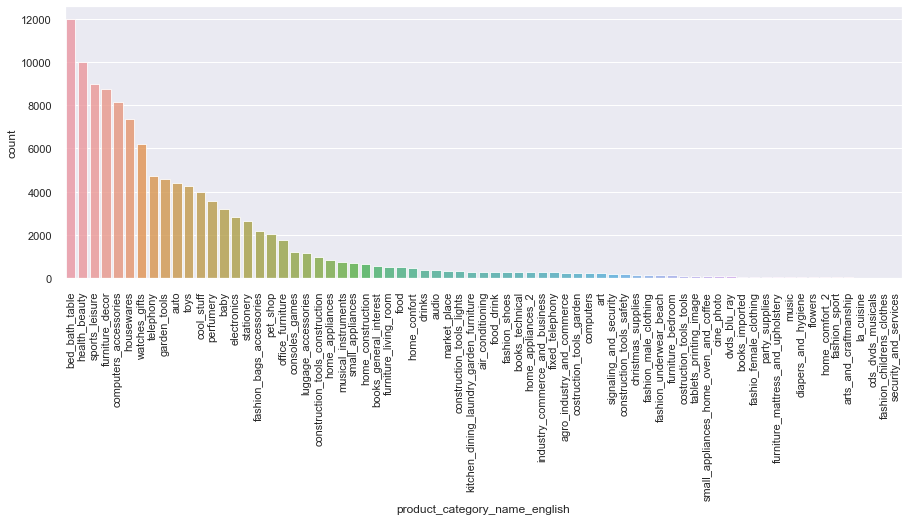

In [8]:
fig = plt.figure(figsize = (15,5))
sns.countplot(df["product_category_name_english"], 
              alpha=0.8, 
              order=df["product_category_name_english"].value_counts().index)
plt.xticks(rotation=90)
plt.show()

Nous allons réduire son nombre de catégories en regroupant les petites avec les plus importantes... Ce regroupement thématique (aussi précis que possible...) sera fait par le biais du dictionnaire de mapping suivant :

In [10]:
dic_categories = {'bed_bath_table' : 'house', 
                  'health_beauty' : 'health_beauty_hygyene', 
                  'sports_leisure' : 'sports_leisure', 
                  'furniture_decor' : 'furniture_decor', 
                  'computers_accessories' : 'computer_multimedia_games', 
                  'housewares' : 'housewares_home_appliances', 
                  'watches_gifts' : 'watches_gifts', 
                  'telephony' : 'telephony', 
                  'garden_tools' : 'garden_construction_tools', 
                  'auto' : 'auto', 
                  'toys' : 'toys', 
                  'cool_stuff' : 'cool_stuff', 
                  'perfumery' : 'perfumery', 
                  'baby' : 'baby', 
                  'electronics' : 'computer_electronics', 
                  'stationery' : 'office_furniture_stationery', 
                  'fashion_bags_accessories' : 'luggage_bags_accessories_fashion', 
                  'pet_shop' : 'pet_shop', 
                  'office_furniture' : 'office_furniture_stationery', 
                  'consoles_games' : 'computer_multimedia_games', 
                  'luggage_accessories' : 'luggage_bags_accessories_fashion', 
                  'construction_tools_construction' : 'garden_construction_tools', 
                  'home_appliances' : 'housewares_home_appliances', 
                  'musical_instruments' : 'computer_electronics', 
                  'small_appliances' : 'housewares_home_appliances',
                  'home_construction' : 'garden_construction_tools', 
                  'books_general_interest' : 'sports_leisure',
                  'furniture_living_room' : 'furniture_decor', 
                  'food' : 'food_drink', 
                  'home_confort' : 'house', 
                  'drinks' : 'food_drink',
                  'audio' : 'computer_electronics', 
                  'market_place' : 'cool_stuff', 
                  'construction_tools_lights' : 'garden_construction_tools',
                  'kitchen_dining_laundry_garden_furniture' : 'house',
                  'air_conditioning' : 'housewares_home_appliances', 
                  'food_drink' : 'food_drink', 
                  'fashion_shoes' : 'luggage_bags_accessories_fashion',
                  'books_technical' : 'sports_leisure', 
                  'home_appliances_2' : 'housewares_home_appliances',
                  'industry_commerce_and_business' : 'office_furniture_stationery', 
                  'fixed_telephony' : 'telephony',
                  'agro_industry_and_commerce' : 'office_furniture_stationery', 
                  'costruction_tools_garden' : 'garden_construction_tools',
                  'computers' : 'computer_electronics', 
                  'art' : 'sports_leisure', 
                  'signaling_and_security' : 'garden_construction_tools',
                  'construction_tools_safety' : 'garden_construction_tools', 
                  'christmas_supplies' : 'sports_leisure',
                  'fashion_male_clothing' : 'luggage_bags_accessories_fashion', 
                  'fashion_underwear_beach' : 'luggage_bags_accessories_fashion',
                  'furniture_bedroom' : 'furniture_decor', 
                  'costruction_tools_tools' : 'garden_construction_tools',
                  'tablets_printing_image' : 'computer_electronics',
                  'small_appliances_home_oven_and_coffee' : 'housewares_home_appliances', 
                  'cine_photo' : 'computer_electronics',
                  'dvds_blu_ray' : 'computer_electronics', 
                  'books_imported' : 'sports_leisure', 
                  'fashio_female_clothing' : 'luggage_bags_accessories_fashion',
                  'party_supplies' : 'sports_leisure', 
                  'furniture_mattress_and_upholstery' : 'furniture_decor',
                  'music' : 'computer_electronics', 
                  'diapers_and_hygiene' : 'health_beauty_hygyene', 
                  'flowers' : 'sports_leisure', 
                  'home_comfort_2' : 'house',
                  'fashion_sport' : 'sports_leisure', 
                  'arts_and_craftmanship' : 'sports_leisure', 
                  'la_cuisine' : 'sports_leisure',
                  'cds_dvds_musicals' : 'computer_electronics', 
                  'fashion_childrens_clothes' : 'luggage_bags_accessories_fashion',
                  'security_and_services' : 'office_furniture_stationery'}

Création d'une nouvelle variable **product_category_red**.

In [9]:
df["product_category_red"] = df["product_category_name_english"].map(dic_categories)

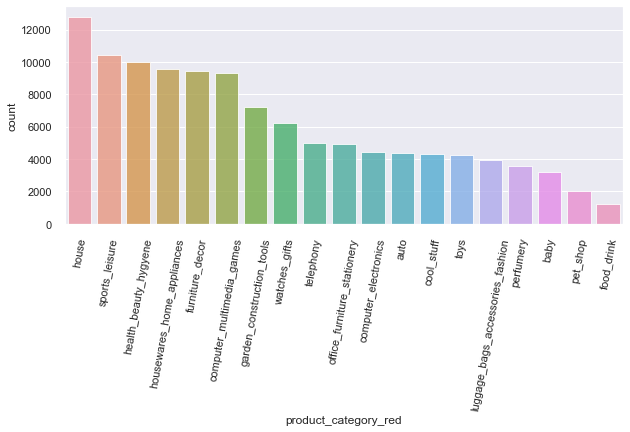

In [276]:
fig = plt.figure(figsize = (10,4))
sns.countplot(df["product_category_red"], 
              alpha=0.8, 
              order=df["product_category_red"].value_counts().index)
plt.xticks(rotation=80)
plt.show()

Sauvegarde du dataset "préparé"...

In [12]:
pickle_out = open("Data/df_cl.pickle", "wb")
pickle.dump(df, pickle_out)
pickle_out.close()

Création de datasets restreints pour chaque classe de clients (**Gold**, **Silver**, **Bronze**).

In [13]:
df = pickle.load(open("Data/df_cl.pickle", "rb"))

df_gold =  df[df["Classe_RF"] == "Gold"]
df_silver = df[df["Classe_RF"] == "Silver"]
df_bronze = df[(df["Classe_RF"] != "Silver") & (df["Classe_RF"] != "Gold")]

# Segmentation 1 - Clients **GOLD**

### Choix des variables

In [14]:
df_gold.columns

Index(['customer_unique_id', 'customer_city', 'customer_state', 'order_status',
       'month', 'day', 'quarter', 'day_q', 'product_category_name_english',
       'order_vol_cm3', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_score', 'review',
       'time_to_carrier', 'time_from_carrier', 'time_to_cust', 'est_time_ship',
       'late_ship', 'late_carrier', 'seller_city', 'seller_state', 'problem',
       'outlier', 'M_class', 'Classe_RF', 'product_category_red'],
      dtype='object')

Quelles variables choisir ?<br><br>Nous allons prendre des variables contribuant à décrire différents aspects du comportemment du client.<br>- Ce qu'il achète avec **product_category_red**<br>- Quand il achète, avec la variable **month** déduite de la date d'achat.<br>- Comment il achète avec le **payment type**.<br>- Un élément pouvant renseigner sur son sentiment suite à son expérience client avec le **review_score**.<br>- En dernier lieu, uniquement pour les clients **Bronze**, nous utiliserons la **M_class**, renseignant sur le montant dépensé. Pour les clients **Gold** et **Silver**, son utilisation ne nous semble pas pertinente.

In [16]:
df_gold = df_gold[['product_category_red', 'review_score', "month", "payment_type"]]
df_gold.head(3)

,product_category_red,review_score,month,payment_type
11,office_furniture_stationery,4,5,credit_card
12,office_furniture_stationery,4,5,credit_card
13,office_furniture_stationery,4,5,credit_card


### Encodage

Nous encodons les variables catégorielles non numériques avec **LabelEncoder**.

In [17]:
df_g_enc = df_gold.copy()

for col in ["product_category_red", "payment_type"] :
    
    le = LabelEncoder()
    df_g_enc[col] = le.fit_transform(df_g_enc[col])

### Standardisation

Nous utiliserons **T-SNE** pour des représentations graphiques, et peut être l'algorithme **DBScan**. Dans ce but nous devons standardiser nos données avec **StandardScaler**.

In [19]:
df_g_scaled = StandardScaler().fit_transform(df_g_enc)

### Réduction T-SNE

In [20]:
tsne = TSNE(n_components=2, init='pca')
tsne_gold = tsne.fit_transform(df_g_scaled)

pickle_out = open("Data/tsne_gold.pickle", "wb")
pickle.dump(tsne_gold, pickle_out)
pickle_out.close()

## **K-Modes** sur clients **Gold**

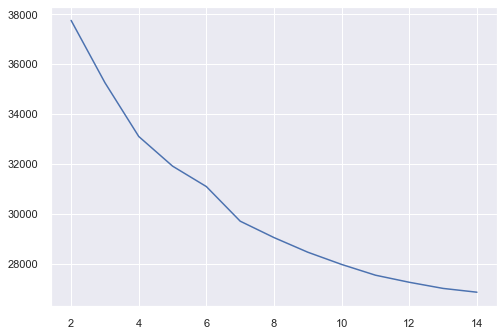

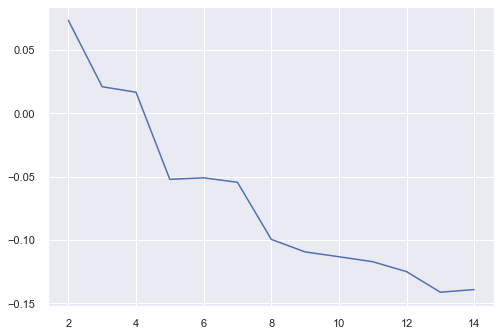

In [21]:
cost = []
score = []

for n in list(range(2,15)):
    km = KModes(n_clusters=n, init = "Cao", verbose=0, random_state = 47)
    km.fit(df_g_enc)
    pred = km.predict(df_g_enc)
    silhouette_avg = silhouette_score(df_g_enc, pred)
    cost.append(km.cost_)
    score.append(silhouette_avg)

y = np.array([i for i in range(2,15,1)])
plt.plot(y,cost)
plt.show()
plt.plot(y,score)
plt.show()

La **méthode du coude** nous inciterait à choisir une valeur comme **k=6**. Cependant **6 groupes** pour une catégorie de clients **Gold** assez peu peuplée, nous parait trop.<br>Nous choisissons donc **K = 2** qui correspond au meilleur **silhouette score**, c'est à dire à la meilleure segmentation en terme de **qualité** des clusters.

In [274]:
km = KModes(n_clusters=2, init = "Cao", verbose=0, random_state = 47)
pred = km.fit_predict(df_g_enc)

silhouette_avg = silhouette_score(df_g_enc, pred)
silhouette_avg

0.07329380363769979

## Analyse graphique

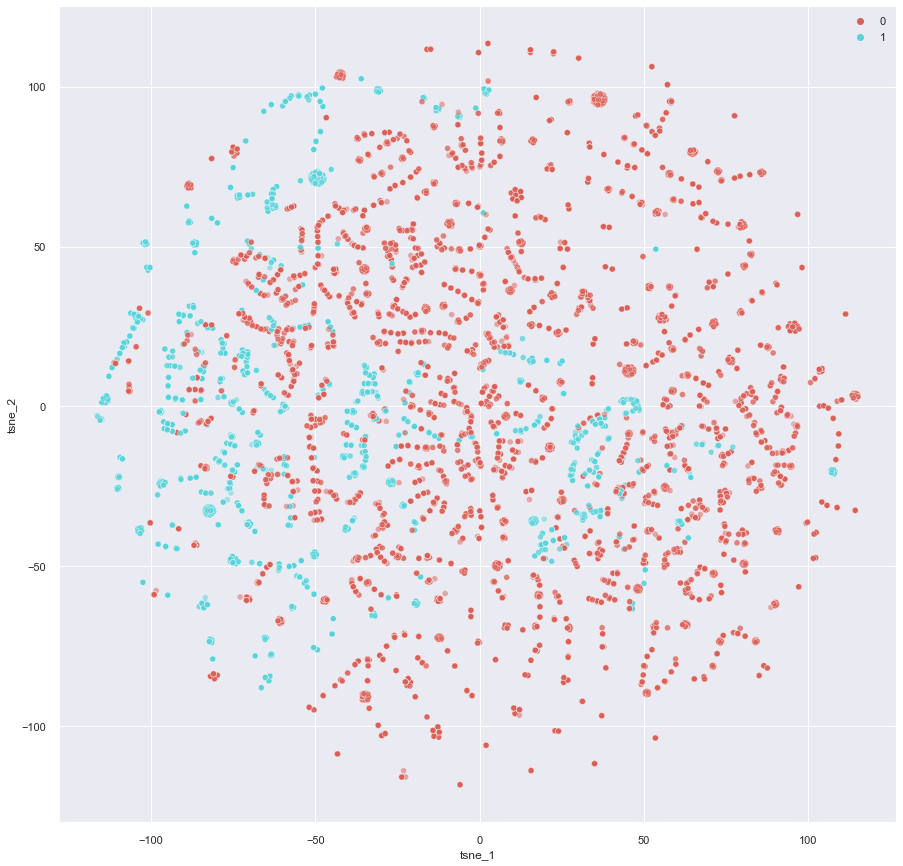

In [275]:
tsne_gold = pd.DataFrame(tsne_gold, columns = ["tsne_1", "tsne_2"])

graph_tsne(tsne_gold, pred, 2)

**K-modes** n'est manifestement pas en mesure de nous offrir une segmentation satisfaisante.

## **DBScan** sur clients **Gold**

En utilisant la fonction **grid_dbs** définie plus haut.

In [28]:
l_metrics = ["euclidean", "manhattan"]
l_ms = range(5,16)
l_eps = np.linspace(0.2, 4, 20)

df_res_gold = grid_dbs(df_g_scaled, l_metrics, l_ms, l_eps, "gold")

(13, 6)

In [35]:
df_res_gold.sort_values("nb_cl", ascending = False).head()

,nb_cl,metric,eps,min_s,pop_cl,temps
0,5,euclidean,0.8,15,"[9646, 3196, 2980, 77, 55]",1.131002
11,5,manhattan,1.0,15,"[9646, 3184, 2980, 76, 68]",0.610001
1,2,manhattan,1.2,5,"[15952, 2]",0.730001
2,2,manhattan,1.2,6,"[15952, 2]",0.730001
3,2,manhattan,1.2,7,"[15952, 2]",0.790001


Nous choisissons une des deux premières segmentations de la liste, en l'occurence la deuxième.

In [271]:
db = DBSCAN(eps=1, min_samples=15, metric = "manhattan", algorithm = 'auto').fit(df_g_scaled)
pred = db.labels_

silhouette_avg = silhouette_score(df_g_scaled, pred)
silhouette_avg

-0.023969622463531577

Le **silhouette score** n'est pas très encourageant. Regardons la représentation graphique...

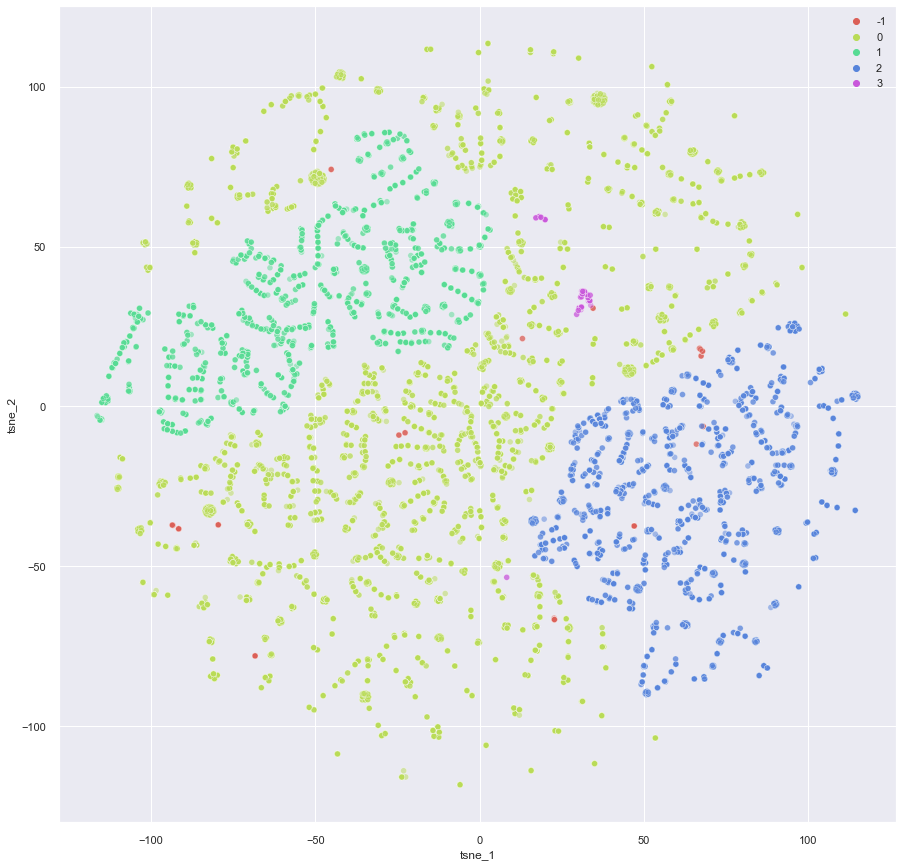

In [273]:
graph_tsne(tsne_gold, pred, 5)

C'est déjà nettement plus intéressant. Si, pour notre interprétation, nous considérons les deux cluster comme du "bruit", nous nous retrouvons avec **3 clusters** définis de manière satisfaisante.

## Interprétation et définition des **personna**

Nous allons récupérer notre cette segmentation dans notre dataset **gold initial**, et tenter de déduire les "traits marquants" de nos profils en fonction de comment nos segments se manifestent au regard de nos variables.

In [39]:
df_gold["cluster"] = pred

Comme décidé de l'observation graphique, nous nous séparons des clusters facteurs de bruit.

In [40]:
df_gold = df_gold[(df_gold["cluster"] != -1) & (df_gold["cluster"] != 3)]

Procédons maintenant à nos observations...

### Clusters au regard de **product_category_red**

On pourrait utiliser un barplot multiple classique...

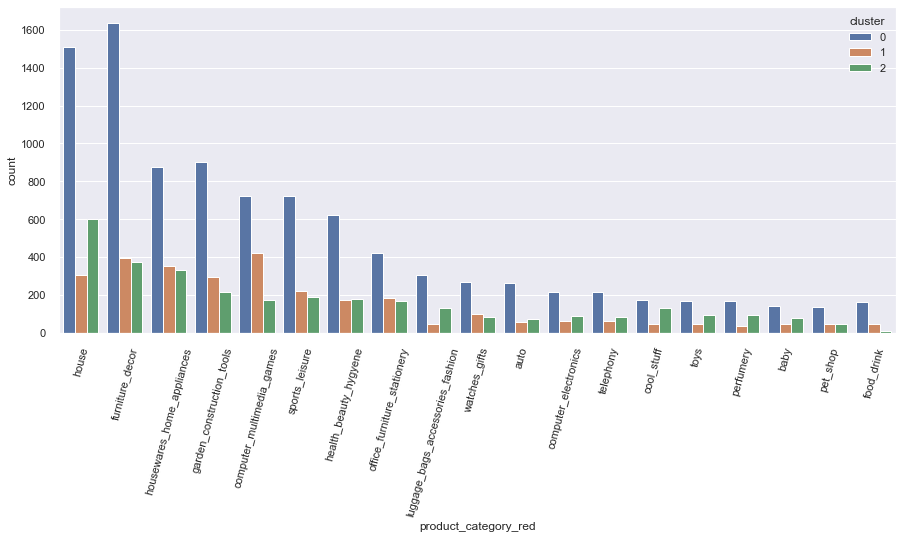

In [43]:
cat = df_gold['product_category_red'].value_counts().index

fig = plt.figure(figsize = (15, 6))
sns.countplot(x=df_gold['product_category_red'], 
              order= cat, 
              hue=df_gold['cluster'])
plt.xticks(np.arange(len(cat)), cat, rotation = 75)
plt.show()

Mais il nous semble plus judicieux d'en utiliser des versions qui nous donnerons le **pourcentage** de population d'un cluster pour chaque catégorie (et non juste la population).

Avant d'être affichés, ces graphs nécessitent une transformation des données. Nous effectuons la transformation et l'affichage au moyen de deux fonctions définies en début d'étude : **transform_data** et **show_graph**.   

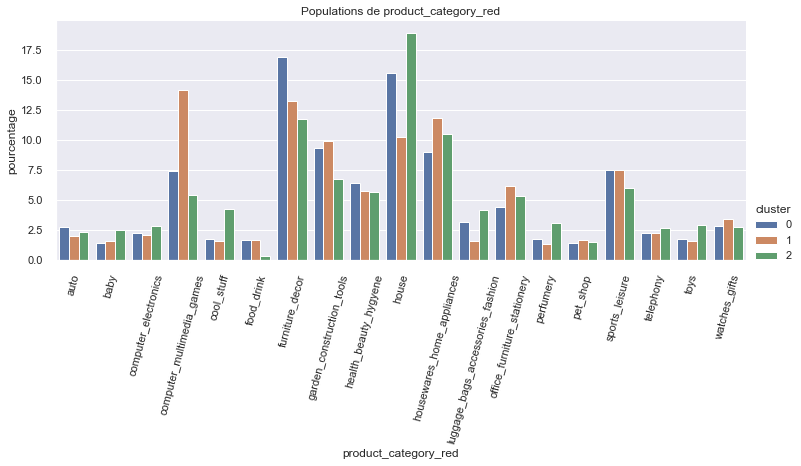

In [220]:
data = transform_data(df_gold, "product_category_red")

show_graph(data, "product_category_red", 4, 2.6, rot = 75)

On peut noter quelques éléments :<br>- Le **cluster 1** a une propension à acheter plus des **produits informatiques** (hardware, software) que les autres, mais moins de produits d'une catégorie **maison**.<br>- Le **cluster 0** aime la **déco**.

### Clusters au regard de **review_score**

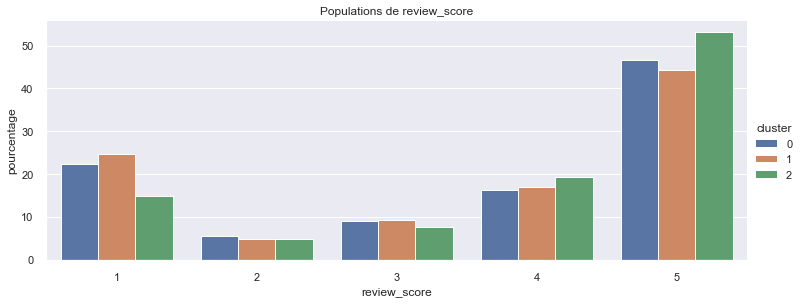

In [219]:
data = transform_data(df_gold, "review_score")

show_graph(data, "review_score", 4, 2.6)

Les reviews score en fonction des clusters sont uniformes...

### Clusters au regard de **month**

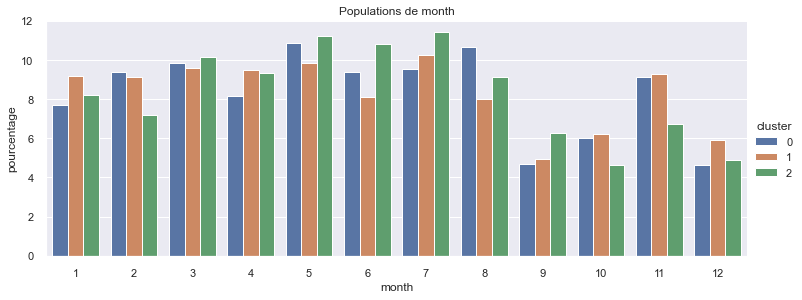

In [218]:
data = transform_data(df_gold, "month")

show_graph(data, "month", 4, 2.6)

Difficile encore de tirer des éléments marquants...

### Clusters au regard de **payment_type**

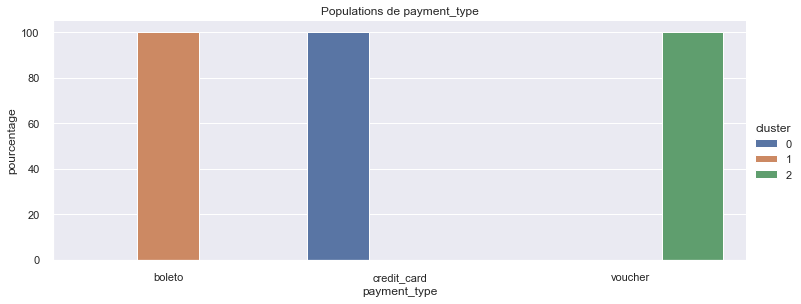

In [217]:
data = transform_data(df_gold, "payment_type")

show_graph(data, "payment_type", 4, 2.6)

Ce graph est beaucoup plus intéressant que les précédents. Il nous montre tout simplement que notre algorithme, en cherchant la meilleure segmentation possible (à 5 clusters ou moins...), n'a pas trouvé mieux que de se caler sur la variable **payment_type**.<br><br>D'après lui, dans nos conditions, **la différenciation la plus pertinente de ce groupe Gold est juste le moyen de paiement**.

# Segmentation 1 - Clients **SILVER**

Nous allons suivre une **démarche identique** à la **précédente**.

### Choix des variables

Nous choisissons les mêmes variables que pour la segmentation **Gold**.

In [221]:
df_silver = df_silver[['product_category_red', 'review_score', "month", "payment_type"]]
df_silver.head(3)

,product_category_red,review_score,month,payment_type
1,office_furniture_stationery,1,11,credit_card
2,office_furniture_stationery,1,11,credit_card
9,office_furniture_stationery,2,1,boleto


### Encodage / Standardisation / Réduction T-SNE

In [222]:
df_s_enc = df_silver.copy()

# Encodage
for col in ["product_category_red", "payment_type"] :
    
    le = LabelEncoder()
    df_s_enc[col] = le.fit_transform(df_s_enc[col])
    
# Standardisation    
df_s_scaled = StandardScaler().fit_transform(df_s_enc)

# Réduction T-SNE (avec sauvegarde)
tsne = TSNE(n_components=2, init='pca')
tsne_silver = tsne.fit_transform(df_s_scaled)

pickle_out = open("Data/tsne_silver.pickle", "wb")
pickle.dump(tsne_silver, pickle_out)
pickle_out.close()    

## **K-Modes** sur clients **Silver**

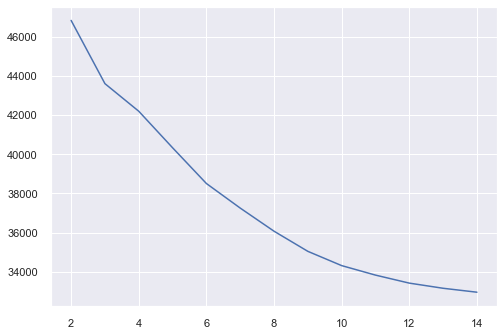

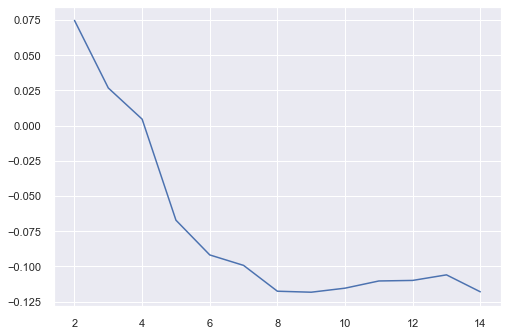

In [224]:
cost = []
score = []

for n in list(range(2,15)):
    km = KModes(n_clusters=n, init = "Cao", verbose=0, random_state = 47)
    km.fit(df_s_enc)
    pred = km.predict(df_s_enc)
    silhouette_avg = silhouette_score(df_s_enc, pred)
    cost.append(km.cost_)
    score.append(silhouette_avg)

y = np.array([i for i in range(2,15,1)])
plt.plot(y,cost)
plt.show()
plt.plot(y,score)
plt.show()

Ici encore, la **méthode du coude** nous incite à utiliser une valeur **k** située autour de **6**. Cependant, cela nous semble faire trop de clusters pour notre groupe de clients. Comme précédemment, nous nous rabattons sur une valeur **k = 2** correspondant au **silhouette_score** le moins mauvais.

In [269]:
km = KModes(n_clusters=2, init = "Cao", verbose=0, random_state = 47)
pred = km.fit_predict(df_s_enc)

silhouette_avg = silhouette_score(df_s_enc, pred)
silhouette_avg

0.07467727400271797

In [226]:
tsne_silver = pd.DataFrame(tsne_silver, columns = ["tsne_1", "tsne_2"])

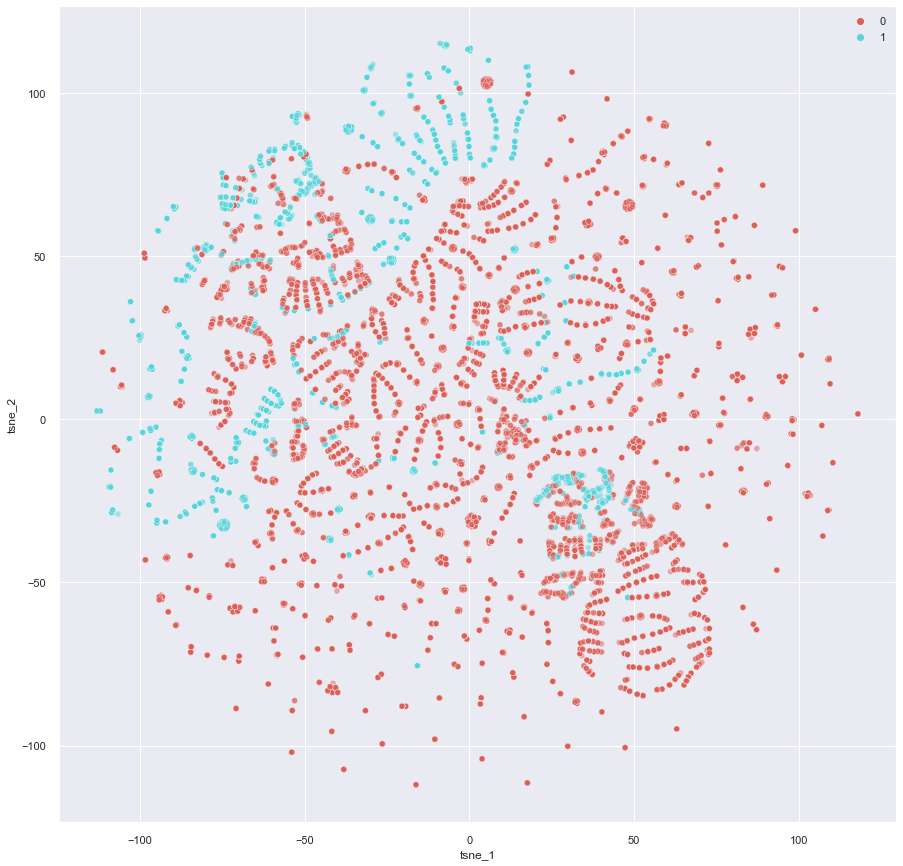

In [270]:
graph_tsne(tsne_silver, pred, 2)

Ici encore, le résultat nous impose d'utiliser **DBScan**.

## **DBScan** sur clients **Silver**

On procède encore par grille avec **grid_dbs**.

In [228]:
l_metrics = ["euclidean", "manhattan"]
l_ms = range(5,16)
l_eps = np.linspace(0.2, 4, 20)

df_res_silver = grid_dbs(df_s_scaled, l_metrics, l_ms, l_eps, "silver")

Ici on dispose de 45 résultats.

In [229]:
df_res_silver.shape

(45, 6)

In [230]:
df_res_silver.head(10)

,nb_cl,metric,eps,min_s,pop_cl,temps
0,5,euclidean,1.0,5,"[14918, 3366, 2068, 232, 2]",2.592148
1,4,euclidean,1.2,5,"[14918, 3366, 2068, 234]",2.964170
2,5,euclidean,1.0,6,"[14918, 3366, 2068, 232, 2]",2.745157
3,4,euclidean,1.2,6,"[14918, 3366, 2068, 234]",3.029173
4,5,euclidean,0.8,7,"[14918, 3366, 2068, 211, 23]",2.200126
5,5,euclidean,1.0,7,"[14918, 3366, 2068, 232, 2]",2.607149
6,4,euclidean,1.2,7,"[14918, 3366, 2068, 234]",3.027173
7,5,euclidean,1.0,8,"[14918, 3366, 2068, 231, 3]",2.637151
8,4,euclidean,1.2,8,"[14918, 3366, 2068, 234]",3.014173
9,5,euclidean,1.0,9,"[14918, 3366, 2068, 231, 3]",2.604149


On choisit les paramètres de la segmentation à **4 clusters** numéro **3**.

In [266]:
db = DBSCAN(eps=1.2, min_samples=6, metric = "euclidean", algorithm = 'auto').fit(df_s_scaled)
pred = db.labels_

silhouette_avg = silhouette_score(df_s_enc, pred)
silhouette_avg

-0.011473160832734707

Représentation graphique

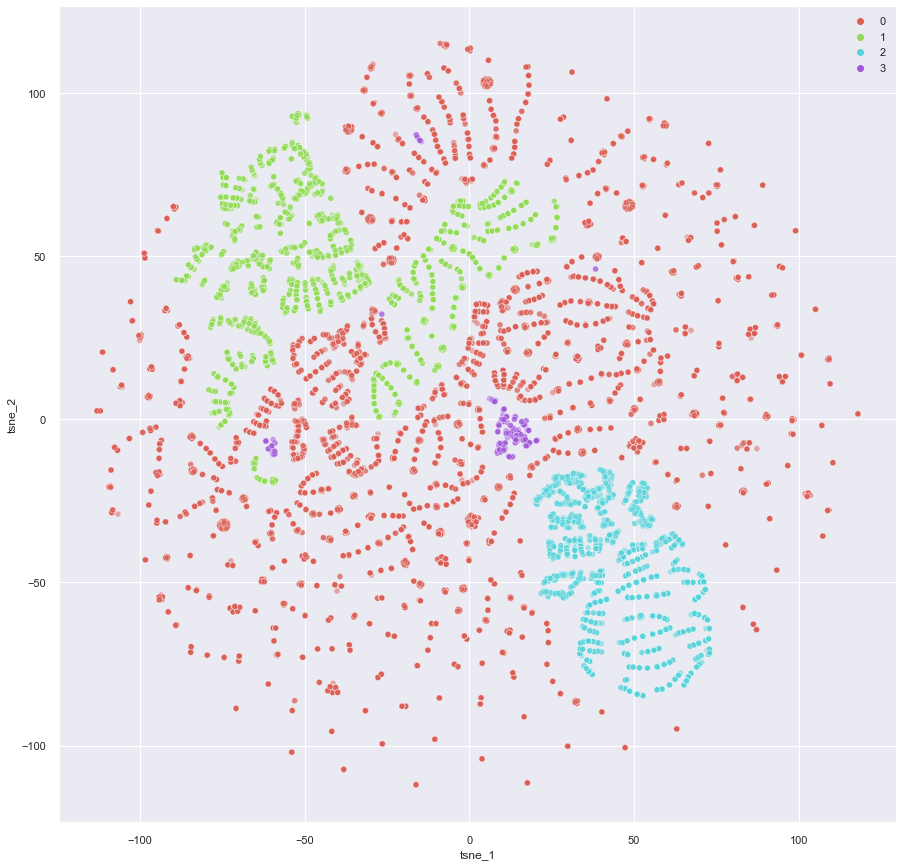

In [267]:
graph_tsne(tsne_silver, pred, 4)

L'utilisation de **DBScan** s'avère une fois encore plus satisfaisante.

## Interprétation et définition des **personna**

In [235]:
df_silver["cluster"] = pred

Comme avant, nous laissons de côté le derniers cluster.

In [236]:
df_silver["cluster"].value_counts()

0    14918
1     3366
2     2068
3      234
Name: cluster, dtype: int64

In [237]:
df_silver = df_silver[df_silver["cluster"] != 3]

### Clusters au regard de **product_category_red**

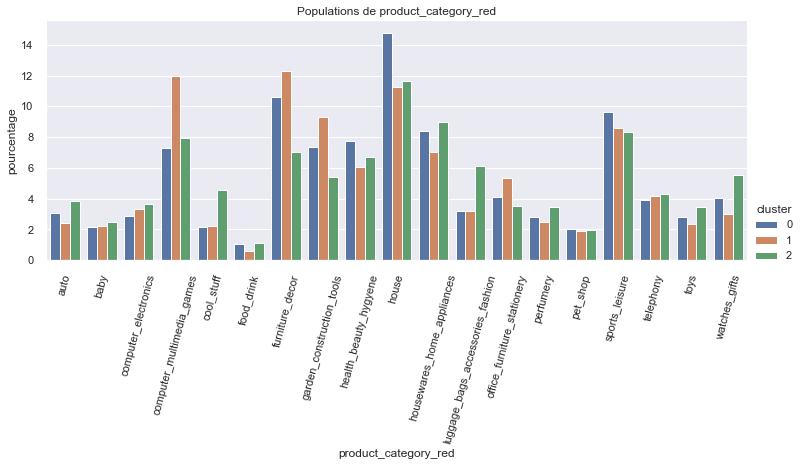

In [238]:
data = transform_data(df_silver, "product_category_red")

show_graph(data, "product_category_red", 4, 2.6, rot = 75)

On retrouve la plus grande appétance du **cluster 1** pour les produits informatiques...

### Clusters au regard de **review_score**

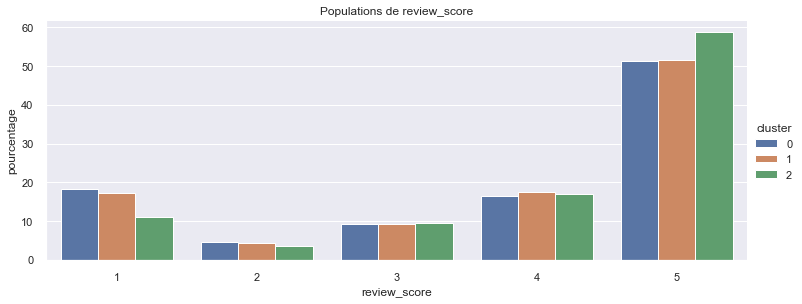

In [239]:
data = transform_data(df_silver, "review_score")

show_graph(data, "review_score", 4, 2.6)

Rien de notable...

### Clusters au regard de **month**

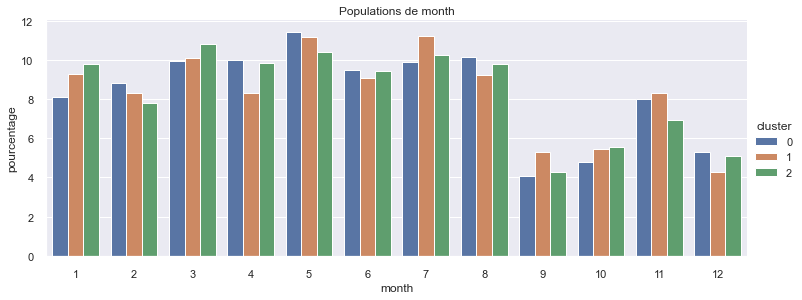

In [240]:
data = transform_data(df_silver, "month")

show_graph(data, "month", 4, 2.6)

Rien avec le mois des achats...

### Clusters au regard de **payment_type**

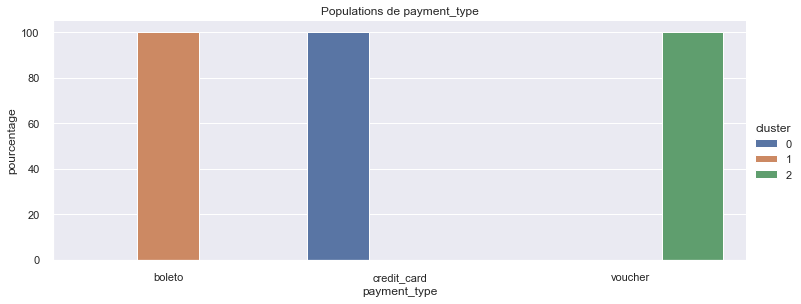

In [241]:
data = transform_data(df_silver, "payment_type")

show_graph(data, "payment_type", 4, 2.6)

Surprise. Avec le groupe de clients **Silver**, et dans nos conditions, la meilleure segmentation se fait sur le **moyen de paiement**.

# Segmentation 3 - Clients **Bronze**

Auparavant, nos clients **bronze** étaient découpés en trois groupes selon leur récence, **b_new**, **b_reg**, et **b_old**. Mais ici nous n'allons pas tenir compte de celle-ci et prendre le groupe d'un bloc.<br><br>Ce groupe de client **bronze** est le plus nombreux. Il représente l'écrasante majorité des clients, qui ont pour principale caractériqtique de n'avoir effectué qu'une seule commande sur le site.<br><br>D'un point de vue "métier", c'est d'elle qu'il serait le plus intéressant de tirer des profils intéressants.<br><br>Pour rappel, dans la segmentation de ce groupe nous utiliserons en plus des précédentes la variable **M_class** décrivant trois catégories de montants dépensés.

In [242]:
df_bronze = df_bronze[['product_category_red', 'review_score', 'month', 'M_class', 'payment_type']]
df_bronze.head(3)

,product_category_red,review_score,month,M_class,payment_type
0,office_furniture_stationery,4,5,2,credit_card
3,office_furniture_stationery,3,5,2,credit_card
4,office_furniture_stationery,4,2,2,credit_card


### Encodage / Standardisation / Réduction T-SNE

In [243]:
df_b_enc = df_bronze.copy()

# Encodage
for col in ["product_category_red", "payment_type"] :
    
    le = LabelEncoder()
    df_b_enc[col] = le.fit_transform(df_b_enc[col])
    
# Standardisation    
df_b_scaled = StandardScaler().fit_transform(df_b_enc)

# Réduction T-SNE (avec sauvegarde)
tsne = TSNE(n_components=2, init='pca')
tsne_bronze = tsne.fit_transform(df_b_scaled)

pickle_out = open("Data/tsne_bronze.pickle", "wb")
pickle.dump(tsne_bronze, pickle_out)
pickle_out.close()

## **K-Modes** sur clients **Bronze**

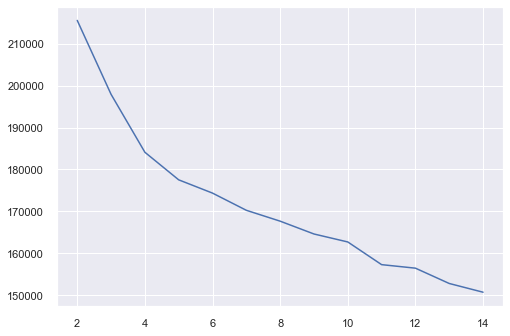

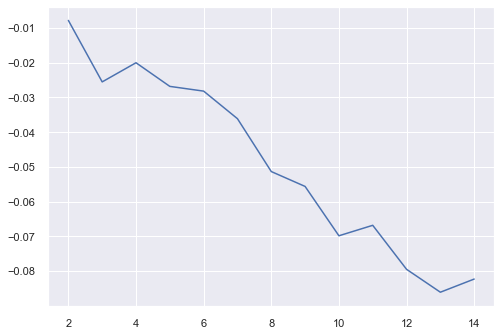

In [244]:
cost = []
score = []

for n in list(range(2,15)):
    km = KModes(n_clusters=n, init = "Cao", verbose=0, random_state = 47)
    km.fit(df_b_enc)
    pred = km.predict(df_b_enc)
    silhouette_avg = silhouette_score(df_b_enc, pred)
    cost.append(km.cost_)
    score.append(silhouette_avg)

y = np.array([i for i in range(2,15,1)])
plt.plot(y,cost)
plt.show()
plt.plot(y,score)
plt.show()

Cette fois, étant donné que nous sommes dans une classe plus **large** et **nombreuse**, nous allons suivre la **règle du coude** et examiner le cas **k = 5**.

In [264]:
km = KModes(n_clusters=5, init = "Cao", verbose=0, random_state = 47)
pred = km.fit_predict(df_b_enc)

silhouette_avg = silhouette_score(df_b_enc, pred)
silhouette_avg

-0.026821630123590838

Représentation graphique

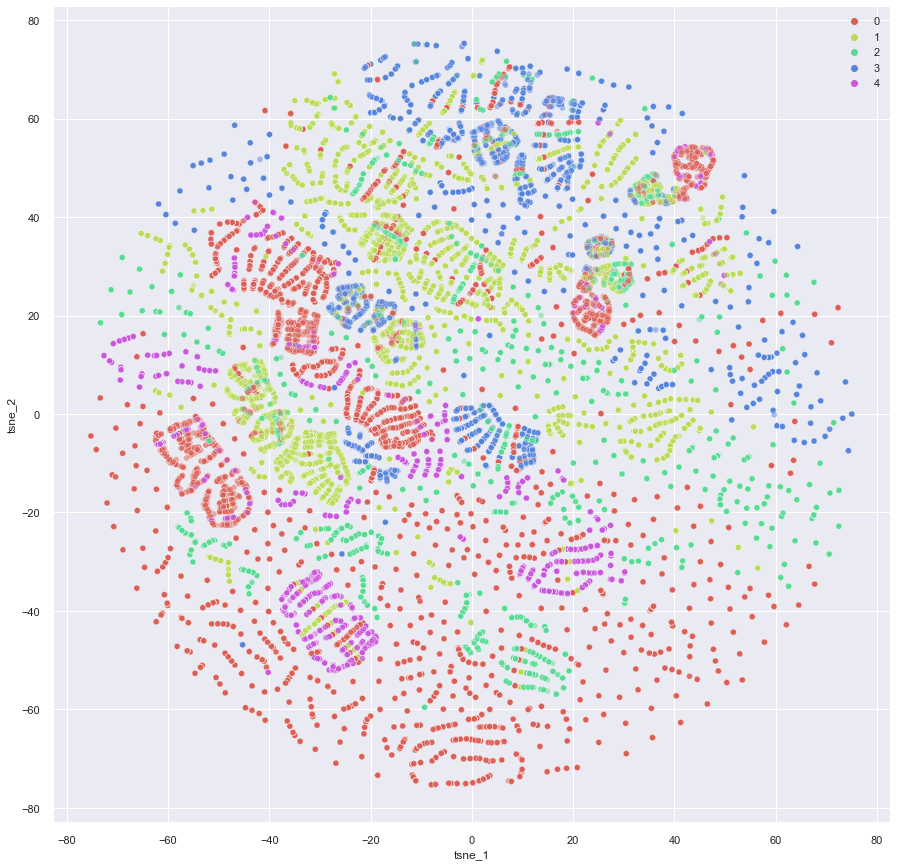

In [265]:
graph_tsne(tsne_bronze, pred, 5)

Nous sommes en présence de la plus esthétique des figures obtenues jusqu'à maintenant, mais la qualité de la segmentation représentée laisse grandement à désirer. Nous nous tournons donc vers **DBScan**...

## **DBScan** sur clients **Bronze**

In [253]:
l_metrics = ["euclidean", "manhattan"]
l_ms = [11, 12, 13, 14, 15]
l_eps = np.linspace(1.4, 1.9, 6)

df_res_bronze = grid_dbs(df_b_scaled, l_metrics, l_ms, l_eps, "bronze")

In [255]:
df_res_bronze.head(10)

,nb_cl,metric,eps,min_s,pop_cl,temps
0,5,euclidean,1.4,11,"[61163, 16277, 1299, 923, 2]",48.753788
1,5,euclidean,1.5,11,"[61163, 16277, 1299, 923, 2]",56.174213
2,5,euclidean,1.6,11,"[61163, 16277, 1299, 924, 1]",65.085723
3,4,euclidean,1.7,11,"[61163, 16277, 1299, 925]",69.039949
4,4,euclidean,1.8,11,"[61163, 16277, 1299, 925]",76.504376
5,4,euclidean,1.9,11,"[61163, 16277, 1299, 925]",497.289443
6,5,euclidean,1.4,12,"[61163, 16277, 1299, 920, 5]",54.729130
7,5,euclidean,1.5,12,"[61163, 16277, 1299, 923, 2]",54.276104
8,5,euclidean,1.6,12,"[61163, 16277, 1299, 924, 1]",61.240503
9,4,euclidean,1.7,12,"[61163, 16277, 1299, 925]",66.159784


On observe encore que les différents paramètres aboutissent en fait à un nombre restreint de segmentations qui semblent très proches les unes des autres.<br><br>Nous choisissons la **4ème** de la liste, avec les paramètres suivant : distance **euclidienne**, **eps = 1.7**, **min_s = 12**.

In [279]:
db = DBSCAN(eps=1.7, min_samples=12, metric = "euclidean", algorithm = 'auto').fit(df_b_scaled)
pred = db.labels_

silhouette_avg = silhouette_score(df_b_scaled, pred)
silhouette_avg

0.21931522547408144

### Analyse graphique

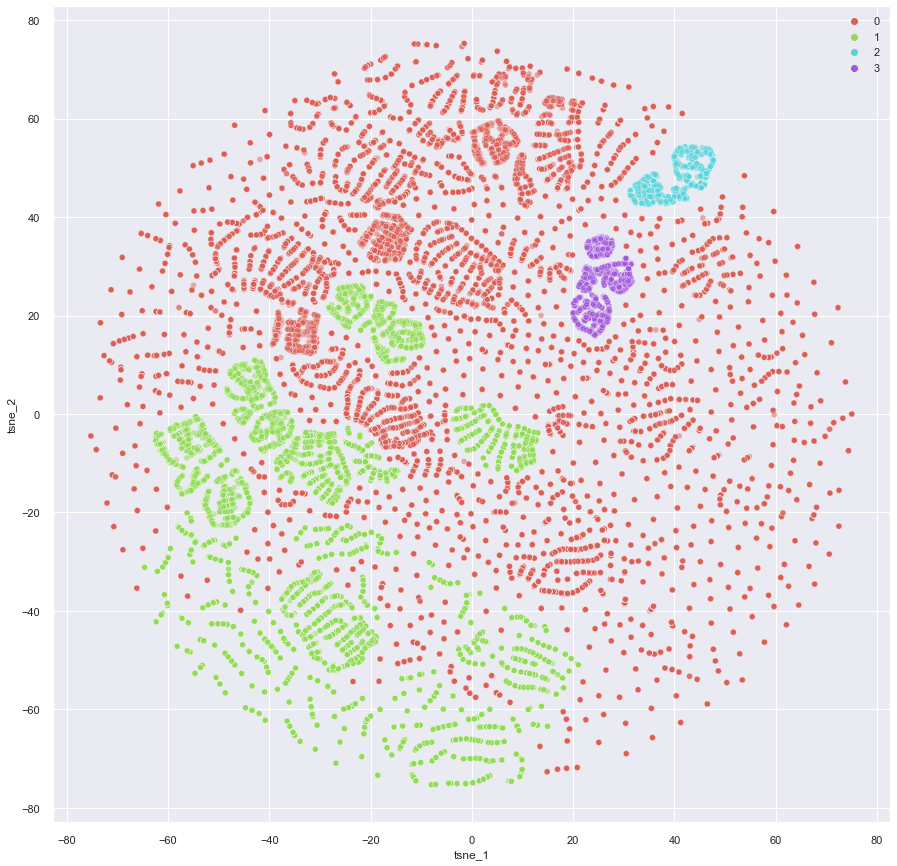

In [263]:
tsne_bronze = pd.DataFrame(tsne_bronze, columns = ["tsne_1", "tsne_2"])

graph_tsne(tsne_bronze, pred, 4)

## Interprétation et définition des **personna**

In [280]:
df_bronze["cluster"] = pred

### Clusters au regard de **product_category_red**

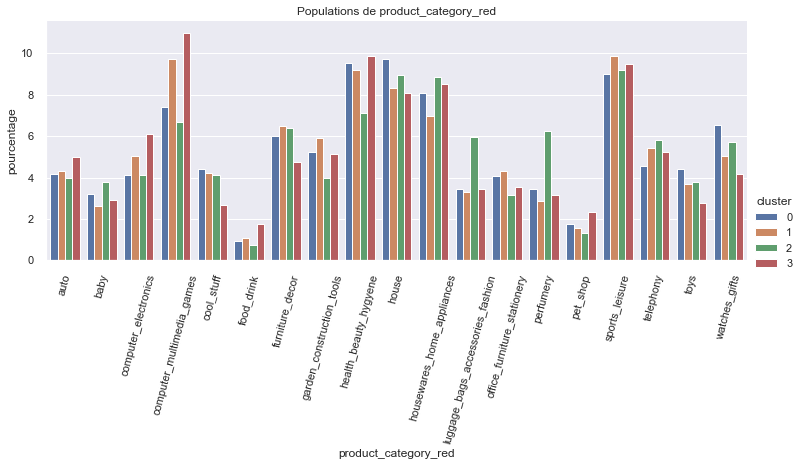

In [281]:
data = transform_data(df_bronze, "product_category_red")

show_graph(data, "product_category_red", 4, 2.6, rot = 75)

Chez nos clients du groupe **bronze**, nous pouvons par exemple prendre note de quelques inclinaisons comme :<br>- l'attrait des clusters 1 et 3 pour les produits informatiques.<br>- l'attrait du cluster 2 pour les accessoires de mode et la parfumerie<br>etc...

### Clusters au regard de **review_score**

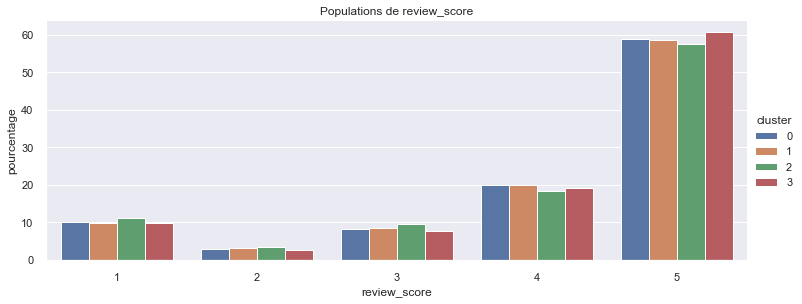

In [283]:
data = transform_data(df_bronze, "review_score")

show_graph(data, "review_score", 4, 2.6)

Ici, rien de particulier...

### Clusters au regard de **month**

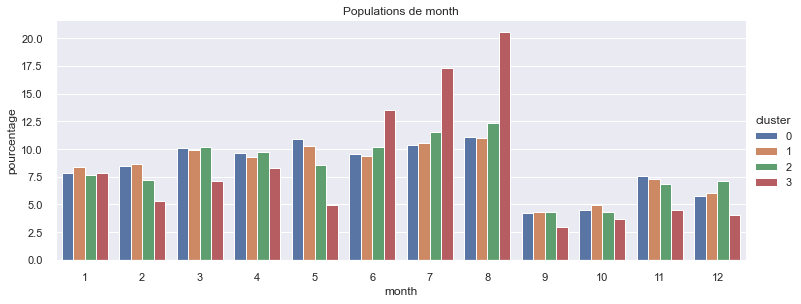

In [284]:
data = transform_data(df_bronze, "month")

show_graph(data, "month", 4, 2.6)

On note une activité supérieure du cluster 3 pour les mois d'été juin, juillet et août.

### Clusters au regard de **M_class**

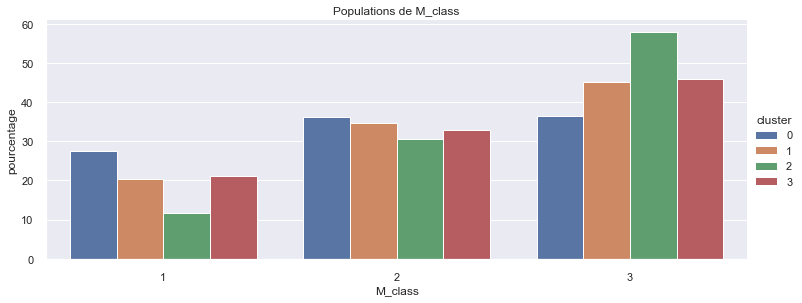

In [286]:
data = transform_data(df_bronze, "M_class")

show_graph(data, "M_class", 4, 2.6)

Le **cluster 1** est légèrement sur-représenté pour la **M_class 1**, celle des "gros achats", et sous représenté dans la **M_class 3**, celle des "petits achats".<br>Pour le **cluster 2** c'est l'inverse. Sous représentation dans la **M_class 1**, sur-représentation dans la **M_class 3**.

### Clusters au regard de **payment_type**

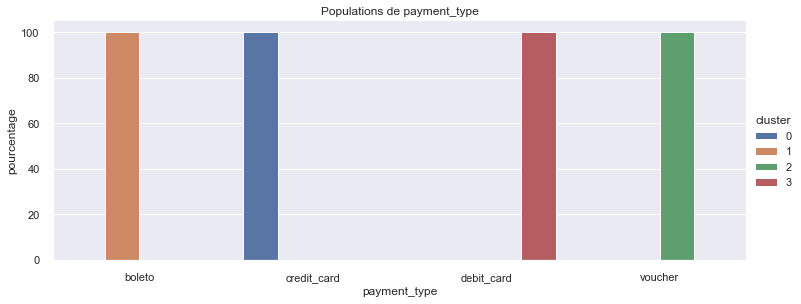

In [287]:
data = transform_data(df_bronze, "payment_type")

show_graph(data, "payment_type", 4, 2.6)

Encore une fois, à partir des données utilisées, il s'avère que l'algorithme utilisé a calqué sa segmentation sur la variable de **type de paiement**.<br><br>En recoupant cela avec nos observations précédentes, on en tirera que :<br>- Boletto et les cartes de débits sont un peu plus utilisés pour les achats de la catégorie informatique.<br>- La carte de débit sert beaucoup l'été.<br>- Voucher, comparativement des autres moyens de paiement, sert plus pour les petits achats que les gros.

## Conclusion de la segmentation.

Toutes nos segmentations de nos différents groupes de clients nous ont invariablement renvoyés à la variable que notre application de machine learning non supervisé a détecté comme décisive dans la construction de **personna** : le **moyen de paiement**.

Ceci nous inspire deux choses.<br><br>Il faut prêter foi aux résultats obtenus et tenir compte des quelques éléments obtenus. Il y a peut-être en effet une action à entreprendre autour du fait que **boletto** est très utilisé pour les achats informatiques, ou que **Voucher** semble pratique pour les petits achats, etc.<br><br>Cependant, il nous faut également réaliser que par ses résultats, notre étude se termine un petit peu en **queue de poisson**.<br><br>Serions nous en mesure de mieux faire avec les éléments dont nous disposons, pourrions nous trouver des **personna** beaucoup plus pertinentes ?<br><br>Nous ne pensons pas. Nous avons utilisé les éléments les plus pertinents susceptibles de reflêter différentes facettes du comportement client et donc de définir des profils types. Ce qui nous a donné les résultats que l'on a vu. Nous ne considérerions pas utile de reprendre ce travail en y insérant des variables géographiques, le volume des paquets, des variables concernant la logistique, etc.<br><br>Nous pensons que pour vraiment déterminer de meilleures **personna** utilisable en terme marketing, nous avons besoin d'autres données. Nous y reviendrons plus tard en conclusion.

# **Quatrième Partie** : **Conclusion**

# **Annexe** : Proposition pour le **suivi** et la **maintenance**